<table style="font-size: 1em; padding: 0; margin: 0;">

<tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #182AEB; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #ffffff;">Deep Learning </span> for Satellite Image Classification (Manning Publications)</span><br/>by <em>Daniel Buscombe</em></strong><br/><br/>
        <strong>> Chapter 5: Model Optimization </strong><br/>
    </p>           
        
<p style="border: 1px solid #182AEB; border-left: 15px solid #182AEB; padding: 10px; text-align:justify;">
    <strong style="color: #182AEB">What you learned in Part 4.</strong>  
    <br/>In Part 4, you trained U-Net models to segment water pixels in imagery
    </p>
    
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">What you will learn in this Part.</strong>  
    <br/>In Part 5, you will optimize the models you made in Part 4. You will first learn how to tune hyper-parameters, add regularization and modify model architectures in several ways, and deal with class imbalance. Then, you will learn how to use a machine learning model known as a ‘fully-connected conditional random field” to refine label images, so labels are as accurate as possible.
    </p>    

#### Preliminaries for Colab

Like Part 3 and 4 previously, below are some convenience functions for those working on Google Colab with a GPU runtime

In [1]:
#load_history = 0
load_history = 1
#load_large_history = 0
load_large_history = 1
if load_history or load_large_history:
  import pickle

In [2]:
#colab = 0
colab = 1

if colab==1:
    %tensorflow_version 2.x
    !pip install --default-timeout=1000 tensorflow-gpu==2.0   

You may have to restart the runtime and/or change runtime type here, if the following doesn't show Tensorflow version 2, and a GPU available

In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


Convenience functions if you need to download example (minimal) imagery sets derived from NWPU and Sentinel-2 cloudless:

In [4]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


#s2 cloudless imagery
file_id = '1iMfIjr_ul49Ghs2ewazjCt8HMPfhY47h'
destination = 's2cloudless_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#s2 cloudless labels
file_id = '1c7MpwKVejoUuW9F2UaF_vps8Vq2RZRfR'
destination = 's2cloudless_label_imagery.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu imagery
file_id = '1gtuqy1VlU8-M5IEMnmiSuTlI5PxQPnGB'
destination = 'nwpu_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)

#nwpu labels
file_id = '1W5LGbcYAcFbG5YjLgX_ekBn0u5Rno35x'
destination = 'nwpu_label_images.zip'
if colab==1:
    download_file_from_google_drive(file_id, destination)                        

In [5]:
import zipfile
def unzip(f):
    """
    f = file to be unzipped
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()
        
if colab==1:
    unzip('s2cloudless_imagery.zip')
    unzip('s2cloudless_label_imagery.zip')   
    unzip('nwpu_images.zip')
    unzip('nwpu_label_images.zip')       

Import the libraries we will need:

In [6]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Training tuning strategies</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
We will set up a baseline model with no optimization using the NWPU imagery, then explore the following training optimization strategies:
<ul>
  <li>Building a bigger model with more layers</li>    
  <li>Using Early Stopping and Adaptive Learning Rates</li> 
  <li>Using a bigger model (and dropout)</li> 
  <li>Using regularization (Batch Normalization)</li> 
  <li>Using residual connections</li> 
</ul>
</p>
        </tr>
        </table>

#### Getting things set up with a baseline model
Zip through all these functions that we defined in the last Part. 

Like in the last Part, we will define the ```unet``` model, create model training callbacks, and generate augmented imagery

In [7]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

def unet(sz = (512, 512, 3)):
  inputs = Input(sz)
  _ = inputs
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    layers.append(_)
    _ = MaxPooling2D() (_)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
  _ = Concatenate(axis=3)([_, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
    _ = Concatenate(axis=3)([_, layers[j]])
    j = j -1 
    
  #classification 
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  outputs = Conv2D(1, 1, activation='sigmoid') (_)
  
  #saving dependencies allows for reloading later
  #dependencies = {
  #    'mean_iou': mean_iou
  #    }  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', 
                metrics = [mean_iou])#,
                #custom_objects=dependencies)
  
  return model 

In [8]:
model = unet()

In [9]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        infile = f'nwpu_images/data/{path}'
        raw = Image.open(infile)
        raw = np.array(raw.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))
                
        #mask post-processing 
        msk  = (pred>60).astype('int') #100       
        msk = np.stack((msk,)*3, axis=-1)
        #msk[msk >= 0.5] = 1 
        #msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()      

We use Keras callbacks to implement learning rate decay if the validation loss does not improve for 5 continues epochs. Called "reduce loss on plateau"

Also, we implement early stopping if the validation loss does not improve for 5 continuous epochs.

In [10]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f'nwpu_images/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('nwpu_images','nwpu_label_images')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>200).astype('int')
        
        mask = mask[:n,:n]

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

We've seen code like the below in the previous Part, setting up batch size, proportion of the dataset to train with, getting randomized lists of test and train file names, and finally setting up generators for model training and testing

In [11]:
batch_size = 8

prop_train = 0.6

all_files = os.listdir('nwpu_images/data')
shuffle(all_files)

split = int(prop_train * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)

A customary check that things worked

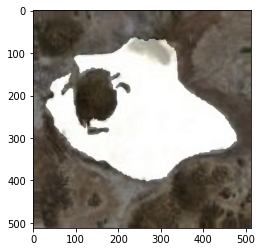

In [12]:
x, y = next(train_generator)
plt.imshow(x[0])
plt.imshow(y[0].squeeze(), cmap='gray', alpha=0.5)

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Optimization strategy: Using Early Stopping<br/>and Adaptive Learning Rates</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
    Neural networks can overfit if they train for too long, but it's hard to know how many epochs is too many without a lot of trial and error, which is not efficient. Automatically computing how many training epochs a model needs or, to put it another way, evaluating when to stop training or <em>early stopping</em>, is achieved by monitoring validation loss during training. If loss doesn't improve for a certain number of epochs, called the <em>patience</em>, model training is terminated. Below <em>patience</em> is set to 5. Another common training strategy to prevent overly long training times is to adaptively change the learning rate during model training. This is achieved by starting with a relatively large number and then decreasing it after every training epoch until a specified minimum <em>min_lr</em> at a certain rate of reduction <em>min_delta</em>.</p>
        </tr>
        </table>

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [14]:
def build_callbacks(filepath, min_delta, min_lr, factor):

    earlystop = EarlyStopping(monitor="val_loss", 
                                  mode="min", patience=5) 
    
    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=5, 
                                    verbose=1, mode='auto', min_delta=min_delta, 
                                    cooldown=5, min_lr=min_lr)

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    callbacks = [model_checkpoint, reduceloss_plat, earlystop, PlotLearning()]

    return callbacks  

In [15]:
# a tolerance for the training.
min_delta = 0.0001

# minimum learning rate (lambda)
min_lr = 0.0001

# the factor applied to the learning rate when the appropriate triggers are made
factor = 0.8

batch_size = 8

filepath = 'unet'+str(batch_size)+'.h5'

In [16]:
train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

42
28


In [17]:
if load_history:
  file_id = '1wIDC0-6ngIoldQr54ss2WdTIf6UT2qfN'
  destination = 'opt_model_1_early_hist'
  download_file_from_google_drive(file_id, destination)
  with open("opt_model_1_early_hist", "rb") as file_pi:
    history = pickle.load(file_pi)
  large_history = history
else:
  history = model.fit_generator(train_generator,
                                epochs = 50, steps_per_epoch = train_steps,
                                validation_data = test_generator, 
                                validation_steps = test_steps,
                                callbacks = build_callbacks(filepath, 
                                                            min_delta, 
                                                            min_lr, 
                                                            factor), 
                                verbose = 0,
                                use_multiprocessing=True)

In [18]:
if not load_history:
  # save model and history to load or graph later
  model.save("opt_model_1_early",save_format="h5")
  
  import pickle
  with open('opt_model_1_early_hist', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
  
  del model

In [19]:
#with open("opt_model_1_early_hist", "rb") as file_pi:
#  history2 = pickle.load(file_pi)

In [20]:
#model2 = tf.keras.models.load_model('opt_model_1_early',
#                                   custom_objects={'mean_iou': mean_iou})

In [21]:
#del history2
#del model2

In [22]:
#del model

In [23]:
#!rm -r nwpu_images
#!rm -r nwpu_label_images
#!rm -r s2cloudless_imagery
#!rm -r s2cloudless_label_imagery
#!rm -r nwpu_images.zip
#!rm -r nwpu_label_images.zip
#!rm -r opt_model_1_early
#!rm -r opt_model_1_early_hist
#!rm -r opt_model_2_big
#!rm -r opt_model_2_big_hist
#!rm -r s2cloudless_imagery.zip
#!rm -r s2cloudless_label_imagery.zip
#!rm -r unet8.h5
#!rm -r large_unet2.h5

<table style="font-size: 1em; padding: 0; margin: 0;">

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #182AEB;">
    </small><br/>Optimization strategy: changing model architecture <br/>use a bigger rocket</h1>
<br/>
<p style="border-left: 15px solid #182AEB; text-align:justify; padding: 0 10px;">
    We'll create a new `unet` function that includes initial filter size <em>f</em> and "bottleneck-creation filter size" <em>ff2</em>. The the previous models, <em>f</em>=8 and <em>ff2</em>=64. This time we make that a user-decision. We'll use <em>f</em>=16 and <em>ff2</em>=128. Because this will massively increase the number of tunable parameters, we will implement a <em>regularization</em> strategy called <em>Dropout</em>. Regularization refers to a training strategy that prevents the model from overfitting the data. This ensures the model generalizes well and is useful for prediction on unseen test data. Dropout is a popular regularization trick, which involves randomly dropping neurons of output layers. The hyperparameter that governs its behavior is a rate. 0.25 means that 25% of neurons, randomly selected, will be dropped. Dropout forces the model to learn robust features, because dropout may deactivate a neuron heavily weighted for a specific feature seen only in training imagery. Dropout thus ensures that more neurons share feature extraction tasks.</p>
        </tr>
        </table>

In [24]:
from tensorflow.keras.layers import Dropout

In [25]:
def unet(sz, f, ff2):
  inputs = Input(sz)
  _ = inputs
  
  #down sampling 
  #f = 8
  layers = []
  
  for i in range(0, 6):
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    layers.append(_)
    _ = MaxPooling2D() (_)
    _ = Dropout(0.25)(_) #added Dropout layer
    f = f*2
  #ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
  _ = Concatenate(axis=3)([_, layers[j]])
  j = j -1 
      
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2D(f, 3, activation='relu', padding='same') (_)
    _ = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_)
    _ = Concatenate(axis=3)([_, layers[j]])
    _ = Dropout(0.25)(_) #added Dropout layer   
    j = j -1 
    
  #classification 
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  _ = Conv2D(f, 3, activation='relu', padding='same') (_)
  outputs = Conv2D(1, 1, activation='sigmoid') (_)

  #saving dependencies allows for reloading later
  dependencies = {
      'mean_iou': mean_iou
      }  

  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', 
                metrics = [mean_iou])
                #custom_objects=dependencies)
  
  return model 

model = unet((512, 512, 3), 16, 128)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 512, 512, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 512, 512, 16) 2320        conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 256, 256, 16) 0           conv2d_28[0][0]                  
____________________________________________________________________________________________

From 6 to 26 million parameters!

In [26]:
# since the model is much larger the batch size should be smaller so training fits in GPU memory
batch_size = 2
# define file path
filepath = 'large_unet'+str(batch_size)+'.h5'

train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

171
114


In [27]:
if load_large_history:
  file_id = '1Ld9xHgid81DIWoOdV4UpFeK10WF-fw6A'
  destination = 'opt_model_2_big_hist'
  download_file_from_google_drive(file_id, destination)
  with open("opt_model_2_big_hist", "rb") as file_pi:
    large_history = pickle.load(file_pi)
else:
  large_history = model.fit_generator(train_generator,
                                      epochs = 50, 
                                      steps_per_epoch = train_steps,
                                      validation_data = test_generator, 
                                      validation_steps = test_steps,
                                      callbacks = build_callbacks(filepath, 
                                                                  min_delta, 
                                                                  min_lr, 
                                                                  factor), 
                                      verbose = 0,
                                      use_multiprocessing=True)

In [28]:
if not load_large_history:
  #save model and history to load or graph later
  model.save("opt_model_2_big",save_format="h5")
  
  with open('opt_model_2_big_hist', 'wb') as file_pi:
    pickle.dump(large_history.history, file_pi)

In [29]:
#from google.colab import drive
#drive.mount('/content/drive')

In [30]:
del model

In [31]:
#large_history.history.keys()
#large_history2.keys()

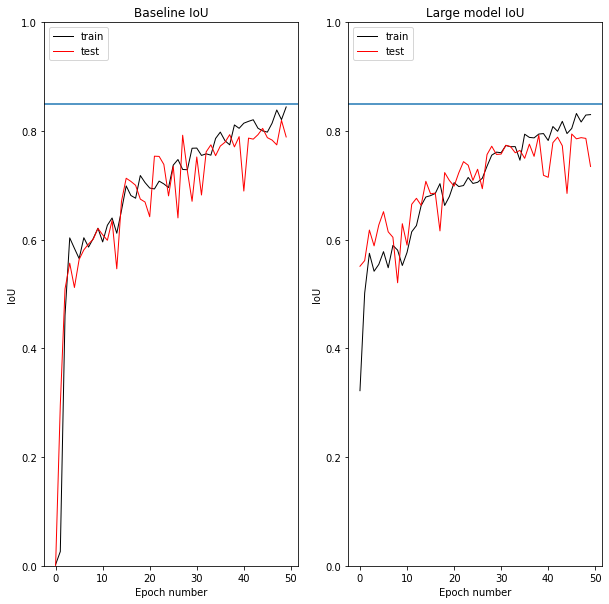

In [32]:
# summarize history for iou
plt.figure(figsize=(10,10))
plt.subplot(121)
if load_history:
  plt.plot(history['mean_iou'],'k',lw=1)
  plt.plot(history['val_mean_iou'],'r',lw=1)
else:
  plt.plot(history.history['mean_iou'],'k',lw=1)
  plt.plot(history.history['val_mean_iou'],'r',lw=1)
plt.ylim(0,1)
plt.axhline(y=0.85)
plt.title('Baseline IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
if load_large_history:
  plt.plot(large_history['mean_iou'],'k',lw=1)
  plt.plot(large_history['val_mean_iou'],'r',lw=1)
else:
  plt.plot(large_history.history['mean_iou'],'k',lw=1)
  plt.plot(large_history.history['val_mean_iou'],'r',lw=1)
plt.ylim(0,1)
plt.axhline(y=0.85)
plt.title('Large model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

plt.show()